In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
from scipy import stats
import seaborn as sns


data_dir: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/6_methcali/dmc_original')
before_files: list[Path] = list((data_dir / 'before').glob('*p.csv'))
after_files: list[Path] = list((data_dir / 'after').glob('*p.csv'))

In [2]:
df: pl.DataFrame = (pl.concat([pl.scan_csv(f,
                                           schema={'sample_pair': pl.String,
                                                   'lab': pl.String,
                                                   'p_type': pl.String,
                                                   'feature': pl.String,
                                                   'fgroup': pl.String,
                                                   'count': pl.Int64,
                                                   'tp': pl.Int64,
                                                   'tn': pl.Int64,
                                                   'fn': pl.Int64,
                                                   'fp': pl.Int64,
                                                   'recall': pl.Float64,
                                                   'precision': pl.Float64,
                                                   'f1_score': pl.Float64,
                                                   'mcc': pl.Float64,
                                                   'ppv': pl.Float64,
                                                   'npv': pl.Float64,
                                                   'roc_auc': pl.Float64})
                                 .drop('feature', 'fgroup')
                                 .with_columns(pl.lit(f.name[: -6]).alias('tool'),
                                               pl.lit(f.parent.name).alias('treatment'))
                                 .select('sample_pair','lab', 'tool', 'p_type',
                                         'treatment', 'count',
                                         'recall',  'precision', 'f1_score',
                                         'mcc', 'ppv', 'npv', 'roc_auc')
                               for f in (before_files + after_files)])
                    .sort(by=['sample_pair', 'lab', 'tool', 'p_type', 'treatment'])
                    .collect()
    )
df

sample_pair,lab,tool,p_type,treatment,count,recall,precision,f1_score,mcc,ppv,npv,roc_auc
str,str,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64
"""BC_vs_BL""","""BS1""","""cpgtools""","""p""","""after""",1191824,0.0,null,0.0,null,null,0.740204,0.5
"""BC_vs_BL""","""BS1""","""cpgtools""","""p""","""before""",1191824,0.960466,0.728997,0.828875,0.771867,0.728997,0.984384,0.857393
"""BC_vs_BL""","""BS1""","""methylkit""","""p""","""after""",1094311,0.84341,0.98591,0.90911,0.873486,0.98591,0.925388,0.91602
"""BC_vs_BL""","""BS1""","""methylkit""","""p""","""before""",1094311,0.959765,0.827088,0.888501,0.83046,0.827088,0.97757,0.879272
"""BC_vs_BL""","""BS1""","""methylsig.beta_binomial""","""p""","""after""",1004277,0.743208,0.997394,0.851741,0.828397,0.997394,0.926699,0.871083
…,…,…,…,…,…,…,…,…,…,…,…,…
"""D6_vs_M8""","""RR1""","""methylsig.beta_binomial""","""p""","""before""",80461,0.9125,0.036049,0.069359,0.176023,0.036049,0.999817,0.90976
"""D6_vs_M8""","""RR1""","""methylsig.binomial""","""p""","""after""",76761,0.20241,0.376513,0.263282,0.246695,0.376513,0.955588,0.589688
"""D6_vs_M8""","""RR1""","""methylsig.binomial""","""p""","""before""",76761,0.25494,0.090497,0.133577,0.068288,0.090497,0.952482,0.535585


In [3]:
def run_paired_test(before: pl.Series,
                    after: pl.Series,
                    alpha: float = .05):
    diff: pl.Series = (before - after).alias('diff')

    # Normality Test
    shapiro_stat, shapiro_p = stats.shapiro(diff)

    print(f'Shapiro-Wilk Normality Test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}')
    if shapiro_p > 0.05:
        print('✅ Normality Test passed. t test can be used.')
        t_stat, p_val = stats.ttest_rel(after, before)
        print(f'\n👉 t test result:')
        print(f'  t = {t_stat:.3f}, samples = {diff.shape[0]}, p = {p_val:.3e}')
        print(f'  average diff = {diff.mean():.3f}')
        test_type = 't test'
        avg_diff = diff.mean()
    else:
        print('❌ Normality Test failed. Wilcoxon test will be used.')
        w_stat, p_val = stats.wilcoxon(before, after)
        print(f'\n👉 Wilcoxon test result:')
        print(f'  W = {w_stat:.0f}, p = {p_val:.3e}')
        print(f'  median diff = {diff.median():.3f}')
        test_type = 'Wilcoxon'
        avg_diff = diff.median()

    avg_change = (after.mean() - before.mean()) * 100 / before.mean()

    if p_val < alpha:
        print('✅ There is a significant difference between before and after treatment (p < 0.05)')
        significant = True
    else:
        print('❌ There is no significant difference between before and after treatment (p ≥ 0.05)')
        significant = False

    return avg_diff, avg_change, test_type, p_val


df_pivot = (df.filter(pl.col('tool').str.contains_any(['methylkit', 'methylsig']),
           pl.col('p_type') == 'p')
   .pivot(index=['lab', 'sample_pair', 'tool'],
          on='treatment', values='mcc'))
run_paired_test(before=df_pivot['before'],
                after=df_pivot['after'])

Shapiro-Wilk Normality Test: W=0.940, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 472, p = 1.543e-23
  median diff = -0.168
✅ There is a significant difference between before and after treatment (p < 0.05)


(-0.1678467705212254, 35.087354662098136, 'Wilcoxon', 1.542996293853424e-23)

In [26]:
wrong = (df.filter(pl.col('tool').str.contains_any(['methylkit', 'methylsig']),
           pl.col('p_type') == 'p')
   .pivot(index=['lab', 'sample_pair', 'tool'],
          on='treatment', values='mcc')
   .with_columns((pl.col('after') - pl.col('before')).alias('diff'))
   .filter(pl.col('diff') < 0))
wrong

lab,sample_pair,tool,after,before,diff
str,str,str,f64,f64,f64
"""BS1""","""BC_vs_BL""","""methylsig.beta_binomial""",0.828397,0.92523,-0.096833
"""BS1""","""BC_vs_BL""","""methylsig.dss""",0.830393,0.857159,-0.026766
"""BS3""","""BC_vs_BL""","""methylsig.beta_binomial""",0.873496,0.924728,-0.051231
"""BS3""","""BC_vs_BL""","""methylsig.dss""",0.863532,0.864141,-0.000608
"""BS4""","""BC_vs_BL""","""methylkit""",0.62829,0.765976,-0.137687
…,…,…,…,…,…
"""BS4""","""BC_vs_BL""","""methylsig.dss""",0.546669,0.754899,-0.20823
"""EM1""","""BC_vs_BL""","""methylsig.beta_binomial""",0.856843,0.923756,-0.066912
"""EM1""","""BC_vs_BL""","""methylsig.dss""",0.85372,0.879566,-0.025847


In [9]:
df.write_csv(data_dir / 'dmc_merged.csv')

In [5]:
from typing import Literal


def run_paired_test(before: pl.Series,
                    after: pl.Series,
                    alpha: float = .05,
                    return_item: Literal['test_type', 'p_val', 'diff', 'pct_change'] = 'p_val'):
    diff: pl.Series = (before - after).alias('diff')

    # Normality Test
    shapiro_stat, shapiro_p = stats.shapiro(diff)

    print(f'Shapiro-Wilk Normality Test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}')
    if shapiro_p > 0.05:
        print('✅ Normality Test passed. t test can be used.')
        t_stat, p_val = stats.ttest_rel(after, before)
        print(f'\n👉 t test result:')
        print(f'  t = {t_stat:.3f}, samples = {diff.shape[0]}, p = {p_val:.3e}')
        print(f'  average diff = {diff.mean():.3f}')
        result_type = 't_test'
        avg_diff = diff.mean()
    else:
        print('❌ Normality Test failed. Wilcoxon test will be used.')
        w_stat, p_val = stats.wilcoxon(before, after)
        print(f'\n👉 Wilcoxon test result:')
        print(f'  W = {w_stat:.0f}, p = {p_val:.3e}')
        print(f'  median diff = {diff.median():.3f}')
        result_type = 'wilcoxon'
        avg_diff = diff.median()

    if p_val < alpha:
        print('✅ There is a significant difference between before and after treatment (p < 0.05)')
    else:
        print('❌ There is no significant difference between before and after treatment (p ≥ 0.05)')

    # significant: bool = True if p_val < alpha else False
    if return_item == 'test_type':
        return result_type
    elif return_item == 'p_val':
        return p_val
    elif return_item == 'diff':
        return avg_diff
    else:
        return 100 * (after.mean() - before.mean()) / before.mean()


def get_result_type(before: pl.Series,
                    after: pl.Series,
                    alpha: float = .05):
    return run_paired_test(before, after, alpha, return_item='test_type')


def get_p_val(before: pl.Series,
               after: pl.Series,
               alpha: float = .05):
    return run_paired_test(before, after, alpha, return_item='p_val')


def get_diff(before: pl.Series,
             after: pl.Series,
             alpha: float = .05):
    return run_paired_test(before, after, alpha, return_item='diff')

def get_pct_change(before: pl.Series,
                   after: pl.Series,
                   alpha: float = .05):
    return run_paired_test(before, after, alpha, return_item='pct_change')

In [7]:
filtered = (df.filter(pl.col('tool').is_in(['methylkit', 'methylsig.beta_binomial',
                                            'methylsig.binomial', 'methylsig.dss']),
                      pl.col('p_type') == 'p')
              .drop_nulls(subset=['mcc'])
              .select('tool', 'sample_pair', 'lab', 'treatment', 'mcc')
              .pivot(index=['tool', 'lab', 'sample_pair'],
                     on='treatment', values='mcc'))
filtered

tool,lab,sample_pair,after,before
str,str,str,f64,f64
"""methylkit""","""BS1""","""BC_vs_BL""",0.873486,0.83046
"""methylsig.beta_binomial""","""BS1""","""BC_vs_BL""",0.828397,0.92523
"""methylsig.binomial""","""BS1""","""BC_vs_BL""",0.838517,0.836452
"""methylsig.dss""","""BS1""","""BC_vs_BL""",0.830393,0.857159
"""methylkit""","""BS2""","""BC_vs_BL""",0.934009,0.790107
…,…,…,…,…
"""methylsig.dss""","""PS3""","""D6_vs_M8""",0.270877,0.270877
"""methylkit""","""RR1""","""D6_vs_M8""",0.186379,0.011139
"""methylsig.beta_binomial""","""RR1""","""D6_vs_M8""",0.353221,0.176023


In [17]:
tool_result1: pl.DataFrame = (filtered.group_by('tool')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_p_val(x.struct.field('before'),
                                                                              x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('p_value'))
                                      .with_columns(pl.col('p_value').list.first().alias('p_value'))
                                      .with_columns(pl.when(pl.col('p_value') < 0.05)
                                                      .then(pl.lit(True))
                                                      .otherwise(pl.lit(False))
                                                      .alias('significant')))
tool_result2: pl.DataFrame = (filtered.group_by('tool')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff'))
                                      .with_columns(pl.col('diff').list.first().alias('diff')))
tool_result3: pl.DataFrame = (filtered.group_by('tool')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff_pct'))
                                      .with_columns(pl.col('diff_pct').list.first().alias('diff_pct')))
tool_result4: pl.DataFrame = (filtered.group_by('tool')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_result_type(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.String)
                                             .alias('test_type'))
                                      .with_columns(pl.col('test_type').list.first().alias('test_type')))

tool_result: pl.DataFrame = (tool_result1.join(other=tool_result2,
                                               on=['tool'],
                                               how='left')
                                         .join(other=tool_result3,
                                               on=['tool'],
                                               how='left')
                                         .join(other=tool_result4,
                                               on=['tool'],
                                               how='left')
                                         .select('tool', 'diff', 'diff_pct', 'test_type',
                                                 'p_value', 'significant')
                                         .rename({'tool': 'Tool',
                                                  'diff': 'Average Diff',
                                                  'diff_pct': 'Average Diff Change (%)',
                                                  'test_type': 'Test Type',
                                                  'p_value': 'P value',
                                                  'significant': 'Significant'}))

Shapiro-Wilk Normality Test: W=0.906, p=0.001
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.912, p=0.002
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.897, p=0.001
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 49, p = 5.028e-06
  median diff = -0.155
✅ There is a significant difference between before and after treatment (p < 0.05)

👉 Wilcoxon test result:
  W = 23, p = 7.202e-07
  median diff = -0.170
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.921, p=0.003
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 37, p = 2.089e-06
  median diff = -0.134
✅ There is a significant difference between before and after treatment (p < 0.05)

👉 Wilcoxon test result:
  W = 10, p = 1.014e-08
  median diff = -0.198
✅ There is a significant difference between before and after treatment

In [18]:
tool_result

Tool,Average Diff,Average Diff Change (%),Test Type,P value,Significant
str,f64,f64,str,f64,bool
"""methylkit""",-0.197757,-0.197757,"""wilcoxon""",1.0136e-8,true
"""methylsig.dss""",-0.13363,-0.13363,"""wilcoxon""",0.000002,true
"""methylsig.binomial""",-0.170416,-0.170416,"""wilcoxon""",7.2017e-7,true
"""methylsig.beta_binomial""",-0.154867,-0.154867,"""wilcoxon""",0.000005,true


In [19]:
sample_pair_result1: pl.DataFrame = (filtered.group_by('sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_p_val(x.struct.field('before'),
                                                                              x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('p_value'))
                                      .with_columns(pl.col('p_value').list.first().alias('p_value'))
                                      .with_columns(pl.when(pl.col('p_value') < 0.05)
                                                      .then(pl.lit(True))
                                                      .otherwise(pl.lit(False))
                                                      .alias('significant')))
sample_pair_result2: pl.DataFrame = (filtered.group_by('sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff'))
                                      .with_columns(pl.col('diff').list.first().alias('diff')))
sample_pair_result3: pl.DataFrame = (filtered.group_by('sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff_pct'))
                                      .with_columns(pl.col('diff_pct').list.first().alias('diff_pct')))
sample_pair_result4: pl.DataFrame = (filtered.group_by('sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_result_type(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.String)
                                             .alias('test_type'))
                                      .with_columns(pl.col('test_type').list.first().alias('test_type')))

sample_pair_result: pl.DataFrame = (sample_pair_result1.join(other=sample_pair_result2,
                                               on=['sample_pair'],
                                               how='left')
                                         .join(other=sample_pair_result3,
                                               on=['sample_pair'],
                                               how='left')
                                         .join(other=sample_pair_result4,
                                               on=['sample_pair'],
                                               how='left')
                                         .select('sample_pair', 'diff', 'diff_pct', 'test_type',
                                                 'p_value', 'significant')
                                         .rename({'sample_pair': 'Sample Pair',
                                                  'diff': 'Average Diff',
                                                  'diff_pct': 'Average Diff Change (%)',
                                                  'test_type': 'Test Type',
                                                  'p_value': 'P value',
                                                  'significant': 'Significant'}))

Shapiro-Wilk Normality Test: W=0.895, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 2, p = 9.087e-08
  median diff = -0.178
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.868, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.948, p=0.034
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 1, p = 8.387e-08
  median diff = -0.216
✅ There is a significant difference between before and after treatment (p < 0.05)

👉 Wilcoxon test result:
  W = 194, p = 1.048e-02
  median diff = -0.034
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.917, p=0.002
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 1.648e-08
  median diff = -0.194
✅ There is a significant difference between before and after treatment (

In [20]:
sample_pair_result

Sample Pair,Average Diff,Average Diff Change (%),Test Type,P value,Significant
str,f64,f64,str,f64,bool
"""D6_vs_D5""",-0.215847,-0.215847,"""wilcoxon""",8.3874e-8,true
"""D6_vs_M8""",-0.194367,-0.194367,"""wilcoxon""",1.6479e-8,true
"""BC_vs_BL""",-0.034182,-0.034182,"""wilcoxon""",0.010478,true
"""D6_vs_F7""",-0.177553,-0.177553,"""wilcoxon""",9.0873e-8,true


In [21]:
lab_result1: pl.DataFrame = (filtered.group_by('lab')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_p_val(x.struct.field('before'),
                                                                              x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('p_value'))
                                      .with_columns(pl.col('p_value').list.first().alias('p_value'))
                                      .with_columns(pl.when(pl.col('p_value') < 0.05)
                                                      .then(pl.lit(True))
                                                      .otherwise(pl.lit(False))
                                                      .alias('significant')))
lab_result2: pl.DataFrame = (filtered.group_by('lab')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff'))
                                      .with_columns(pl.col('diff').list.first().alias('diff')))
lab_result3: pl.DataFrame = (filtered.group_by('lab')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff_pct'))
                                      .with_columns(pl.col('diff_pct').list.first().alias('diff_pct')))
lab_result4: pl.DataFrame = (filtered.group_by('lab')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_result_type(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.String)
                                             .alias('test_type'))
                                      .with_columns(pl.col('test_type').list.first().alias('test_type')))

lab_result: pl.DataFrame = (lab_result1.join(other=lab_result2,
                                               on=['lab'],
                                               how='left')
                                         .join(other=lab_result3,
                                               on=['lab'],
                                               how='left')
                                         .join(other=lab_result4,
                                               on=['lab'],
                                               how='left')
                                         .select('lab', 'diff', 'diff_pct', 'test_type',
                                                 'p_value', 'significant')
                                         .rename({'lab': 'Tool',
                                                  'diff': 'Average Diff',
                                                  'diff_pct': 'Average Diff Change (%)',
                                                  'test_type': 'Test Type',
                                                  'p_value': 'P value',
                                                  'significant': 'Significant'}))

Shapiro-Wilk Normality Test: W=0.873, p=0.031
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.949, p=0.477
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = 17.057, samples = 16, p = 3.125e-11
  average diff = -0.177
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.933, p=0.270
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = 5.565, samples = 16, p = 5.407e-05
  average diff = -0.144
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.586, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.930, p=0.247
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = 13.998, samples = 16, p = 5.132e-10
  average diff = -0.261
✅ There is a significant difference between before and after treatment (p < 0.05)

👉 Wilcoxon test result:
  W = 0

In [22]:
lab_result

Tool,Average Diff,Average Diff Change (%),Test Type,P value,Significant
str,f64,f64,str,f64,bool
"""EM3""",-0.256986,-0.256986,"""t_test""",9.0400e-10,true
"""PS1""",0.0,0.0,"""wilcoxon""",0.067889,false
"""PS2""",0.0,0.0,"""wilcoxon""",0.067889,false
"""BS2""",-0.22081,-0.22081,"""t_test""",1.1335e-7,true
"""EM1""",-0.144262,-0.144262,"""t_test""",0.000054,true
…,…,…,…,…,…
"""BS4""",-0.008884,-0.008884,"""wilcoxon""",0.86026,false
"""RR1""",-0.17692,-0.17692,"""t_test""",3.1247e-11,true
"""BS3""",-0.16359,-0.16359,"""t_test""",0.000018,true


In [23]:
tool_pair1: pl.DataFrame = (filtered.group_by('tool', 'sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_p_val(x.struct.field('before'),
                                                                              x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('p_value'))
                                      .with_columns(pl.col('p_value').list.first().alias('p_value'))
                                      .with_columns(pl.when(pl.col('p_value') < 0.05)
                                                      .then(pl.lit(True))
                                                      .otherwise(pl.lit(False))
                                                      .alias('significant')))
tool_pair2: pl.DataFrame = (filtered.group_by('tool', 'sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff'))
                                      .with_columns(pl.col('diff').list.first().alias('diff')))
tool_pair3: pl.DataFrame = (filtered.group_by('tool', 'sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff_pct'))
                                      .with_columns(pl.col('diff_pct').list.first().alias('diff_pct')))
tool_pair4: pl.DataFrame = (filtered.group_by('tool', 'sample_pair')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_result_type(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.String)
                                             .alias('test_type'))
                                      .with_columns(pl.col('test_type').list.first().alias('test_type')))

tool_pair: pl.DataFrame = (tool_pair1.join(other=tool_pair2,
                                               on=['tool', 'sample_pair'],
                                               how='left')
                                         .join(other=tool_pair3,
                                               on=['tool', 'sample_pair'],
                                               how='left')
                                         .join(other=tool_pair4,
                                               on=['tool', 'sample_pair'],
                                               how='left')
                                         .select('tool', 'sample_pair', 'diff', 'diff_pct', 'test_type',
                                                 'p_value', 'significant')
                                         .rename({'tool': 'Tool',
                                                  'sample_pair': 'Sample Pair',
                                                  'diff': 'Average Diff',
                                                  'diff_pct': 'Average Diff Change (%)',
                                                  'test_type': 'Test Type',
                                                  'p_value': 'P value',
                                                  'significant': 'Significant'}))

Shapiro-Wilk Normality Test: W=0.838, p=0.026
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.872, p=0.069
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = -0.341, samples = 12, p = 7.397e-01
  average diff = 0.012
❌ There is no significant difference between before and after treatment (p ≥ 0.05)
Shapiro-Wilk Normality Test: W=0.850, p=0.036
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.845, p=0.032
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.896, p=0.141
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = 1.427, samples = 12, p = 1.813e-01
  average diff = -0.045
❌ There is no significant difference between before and after treatment (p ≥ 0.05)
Shapiro-Wilk Normality Test: W=0.963, p=0.820
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = 2.936, samples = 12, p = 1.355e-02
  average diff = -0.102
✅ There is a si

In [ ]:
tool_pair = tool_pair.sort(by=['Tool', 'Sample Pair'])
tool_pair

Tool,Sample Pair,Average Diff,Average Diff Change (%),Test Type,P value,Significant
str,str,f64,f64,str,f64,bool
"""methylkit""","""BC_vs_BL""",-0.101627,-0.101627,"""t_test""",0.013554,true
"""methylkit""","""D6_vs_D5""",-0.24678,-0.24678,"""wilcoxon""",0.000977,true
"""methylkit""","""D6_vs_F7""",-0.175296,-0.175296,"""t_test""",0.000012,true
"""methylkit""","""D6_vs_M8""",-0.207782,-0.207782,"""wilcoxon""",0.000488,true
"""methylsig.beta_binomial""","""BC_vs_BL""",0.011674,0.011674,"""t_test""",0.73971,false
…,…,…,…,…,…,…
"""methylsig.binomial""","""D6_vs_M8""",-0.190548,-0.190548,"""wilcoxon""",0.001953,true
"""methylsig.dss""","""BC_vs_BL""",-0.017584,-0.017584,"""t_test""",0.523148,false
"""methylsig.dss""","""D6_vs_D5""",-0.169677,-0.169677,"""wilcoxon""",0.003906,true


In [11]:
filtered = df.filter(pl.col('tool').is_in(['methylkit', 'methylsig.beta_binomial', 'methylsig.binomial', 'methylsig.dss']),
          pl.col('p_type') == 'p').drop_nulls(subset=['mcc'])
filtered.write_csv(data_dir / 'dmc_filtered.csv')

In [6]:
filtered_pivot: pl.DataFrame = (pl.read_csv(data_dir / 'dmc_filtered.csv')
                                  .select('sample_pair', 'lab', 'tool', 'treatment', 'mcc')
                                  .pivot(index=['sample_pair', 'lab', 'tool'],
                                         on='treatment', values='mcc')
                                  .with_columns((pl.col('after') - pl.col('before')).alias('diff')))
filtered_pivot

sample_pair,lab,tool,after,before,diff
str,str,str,f64,f64,f64
"""BC_vs_BL""","""BS1""","""methylkit""",0.873486,0.83046,0.043026
"""BC_vs_BL""","""BS1""","""methylsig.beta_binomial""",0.828397,0.92523,-0.096833
"""BC_vs_BL""","""BS1""","""methylsig.binomial""",0.838517,0.836452,0.002065
"""BC_vs_BL""","""BS1""","""methylsig.dss""",0.830393,0.857159,-0.026766
"""BC_vs_BL""","""BS2""","""methylkit""",0.934009,0.790107,0.143902
…,…,…,…,…,…
"""D6_vs_M8""","""PS3""","""methylsig.dss""",0.270877,0.270877,0.0
"""D6_vs_M8""","""RR1""","""methylkit""",0.186379,0.011139,0.175241
"""D6_vs_M8""","""RR1""","""methylsig.beta_binomial""",0.353221,0.176023,0.177198


In [7]:
def run_paired_test(before: pl.Series,
                    after: pl.Series,
                    alpha: float = .05):
    diff: pl.Series = (before - after).alias('diff')

    # Normality Test
    shapiro_stat, shapiro_p = stats.shapiro(diff)

    print(f'Shapiro-Wilk Normality Test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}')
    if shapiro_p > 0.05:
        print('✅ Normality Test passed. t test can be used.')
        t_stat, p_val = stats.ttest_rel(after, before)
        print(f'\n👉 t test result:')
        print(f'  t = {t_stat:.3f}, samples = {diff.shape[0]}, p = {p_val:.3e}')
        print(f'  average diff = {diff.mean():.3f}')
        test_type = 't test'
        avg_diff = diff.mean()
    else:
        print('❌ Normality Test failed. Wilcoxon test will be used.')
        w_stat, p_val = stats.wilcoxon(before, after)
        print(f'\n👉 Wilcoxon test result:')
        print(f'  W = {w_stat:.0f}, p = {p_val:.3e}')
        print(f'  median diff = {diff.median():.3f}')
        test_type = 'Wilcoxon'
        avg_diff = diff.median()

    avg_change = (after.mean() - before.mean()) * 100 / before.mean()

    if p_val < alpha:
        print('✅ There is a significant difference between before and after treatment (p < 0.05)')
        significant = True
    else:
        print('❌ There is no significant difference between before and after treatment (p ≥ 0.05)')
        significant = False

    return avg_diff, avg_change, test_type, p_val

In [8]:
paired_test_result = []
for sample_pair in ('D6_vs_D5', 'D6_vs_F7', 'D6_vs_M8', 'BC_vs_BL'):
    for tool in ('methylkit', 'methylsig.beta_binomial', 'methylsig.binomial', 'methylsig.dss'):
        print(f'\n=== {sample_pair} - {tool} ===')
        subset = filtered_pivot.filter((pl.col('sample_pair') == sample_pair) &
                                      (pl.col('tool') == tool))
        avg_diff, avg_change, test_type, p_val = run_paired_test(before=subset['before'],
                                                                 after=subset['after'])
        paired_test_result.append({
            'sample_pair': sample_pair, 'tool': tool,
            'avg_diff': avg_diff,
            'avg_change_pct': avg_change,
            'test_type': test_type,
            'p_value': p_val,
            'significant': True if p_val < 0.05 else False
        })


=== D6_vs_D5 - methylkit ===
Shapiro-Wilk Normality Test: W=0.842, p=0.029
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 9.766e-04
  median diff = -0.247
✅ There is a significant difference between before and after treatment (p < 0.05)

=== D6_vs_D5 - methylsig.beta_binomial ===
Shapiro-Wilk Normality Test: W=0.837, p=0.026
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 1, p = 7.812e-03
  median diff = -0.215
✅ There is a significant difference between before and after treatment (p < 0.05)

=== D6_vs_D5 - methylsig.binomial ===
Shapiro-Wilk Normality Test: W=0.838, p=0.026
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 3.906e-03
  median diff = -0.212
✅ There is a significant difference between before and after treatment (p < 0.05)

=== D6_vs_D5 - methylsig.dss ===
Shapiro-Wilk Normality Test: W=0.851, p=0.038
❌ Normality Test failed. Wilcoxon test will be used

In [11]:
paired_test_result = pl.DataFrame(paired_test_result).sort(by=['tool', 'sample_pair'])
paired_test_result

sample_pair,tool,avg_diff,avg_change_pct,test_type,p_value,significant
str,str,f64,f64,str,f64,bool
"""BC_vs_BL""","""methylkit""",-0.101627,13.218663,"""t test""",0.013554,true
"""D6_vs_D5""","""methylkit""",-0.24678,70.290847,"""Wilcoxon""",0.000977,true
"""D6_vs_F7""","""methylkit""",-0.175296,86.103178,"""t test""",0.000012,true
"""D6_vs_M8""","""methylkit""",-0.207782,96.884391,"""Wilcoxon""",0.000488,true
"""BC_vs_BL""","""methylsig.beta_binomial""",0.011674,-1.316888,"""t test""",0.73971,false
…,…,…,…,…,…,…
"""D6_vs_M8""","""methylsig.binomial""",-0.190548,70.633711,"""Wilcoxon""",0.001953,true
"""BC_vs_BL""","""methylsig.dss""",-0.017584,2.090142,"""t test""",0.523148,false
"""D6_vs_D5""","""methylsig.dss""",-0.169677,37.695159,"""Wilcoxon""",0.003906,true


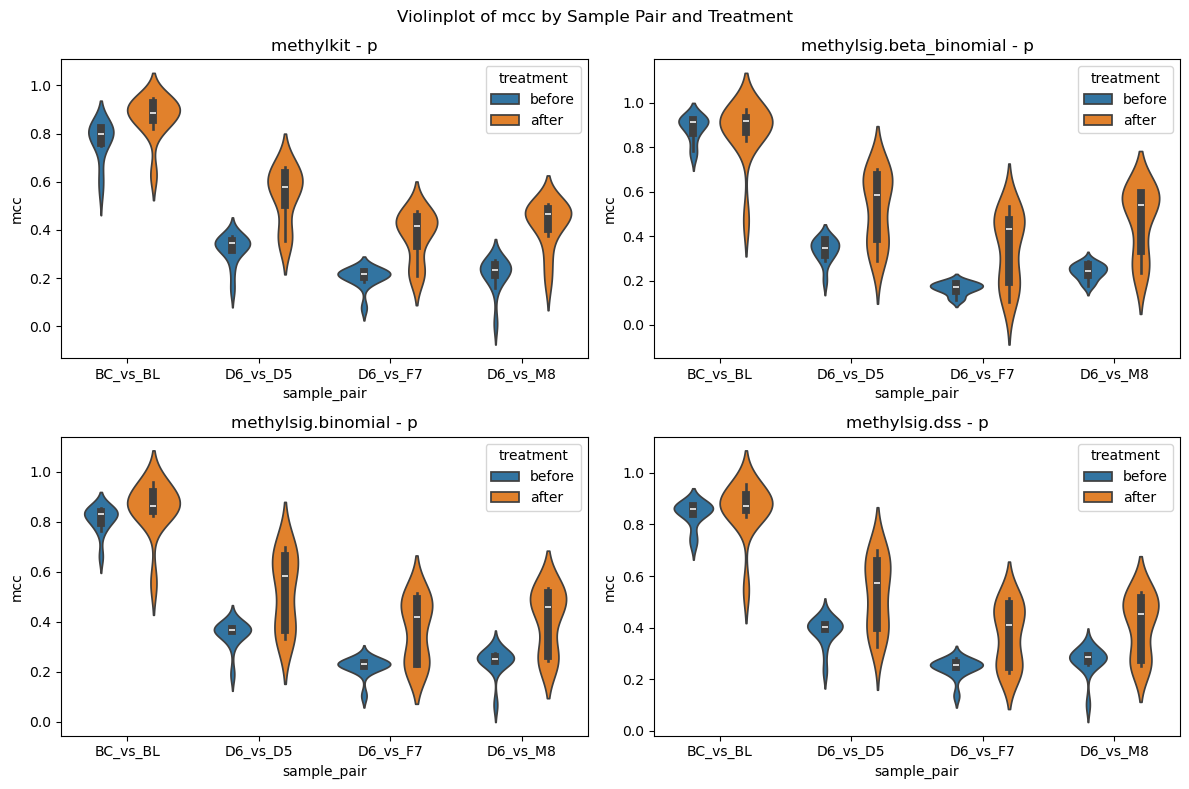

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

tools = ['methylkit', 'methylsig.beta_binomial', 'methylsig.binomial', 'methylsig.dss']
p_types = ['p', 'q']
metric = 'mcc'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

plt.suptitle(f'Violinplot of {metric} by Sample Pair and Treatment')

for i, tool in enumerate(tools):
    ax = axes[i]
    sns.violinplot(data=df.filter(pl.col('tool') == tool).to_pandas(),
                   x='sample_pair', y=metric, hue='treatment', ax=ax,
                   hue_order=['before', 'after'])
    ax.set_title(f'{tool} - p')


plt.tight_layout()

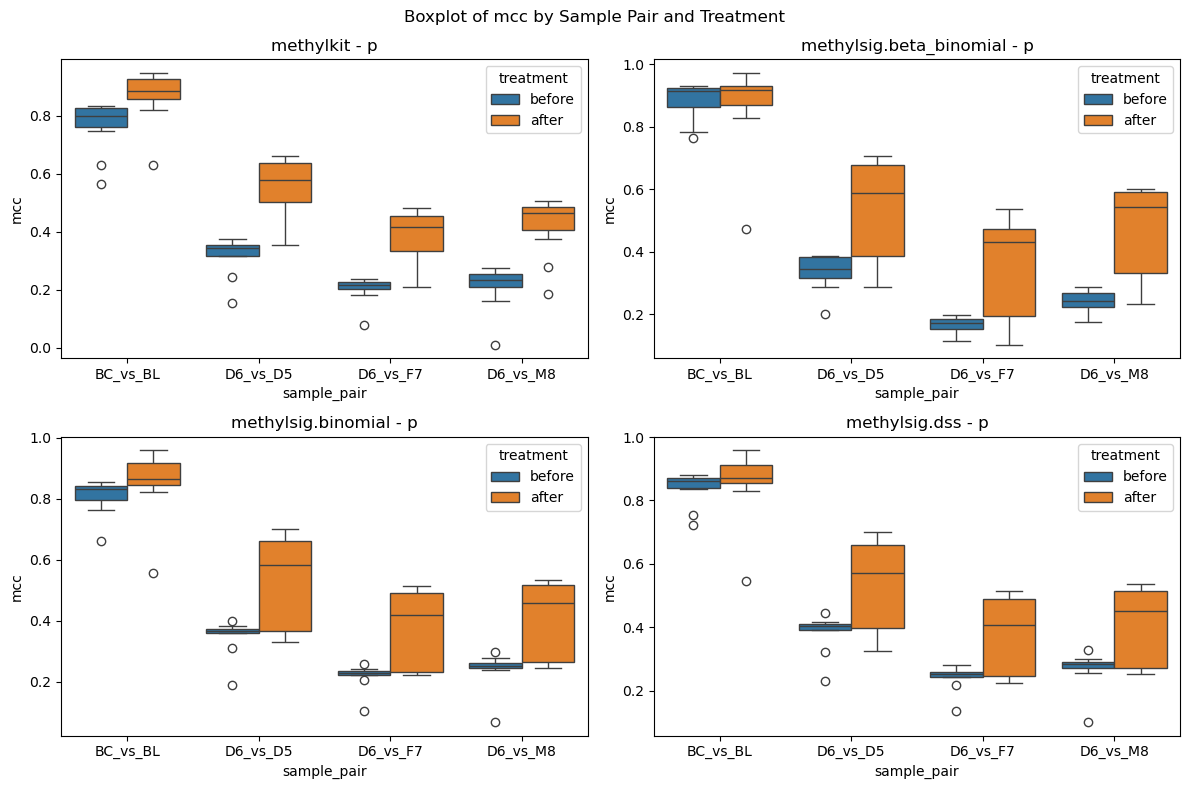

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

tools = ['methylkit', 'methylsig.beta_binomial', 'methylsig.binomial', 'methylsig.dss']
p_types = ['p', 'q']
metric = 'mcc'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

plt.suptitle(f'Boxplot of {metric} by Sample Pair and Treatment')

for i, tool in enumerate(tools):
    ax = axes[i]
    sns.boxplot(data=df.filter(pl.col('tool') == tool).to_pandas(),
                x='sample_pair', y=metric, hue='treatment', ax=ax,
                hue_order=['before', 'after'])
    ax.set_title(f'{tool} - p')


plt.tight_layout()